In [2]:
# pip install opencv-python

import cv2
import numpy as np

In [4]:
def compute_similarity(image1_path, image2_path):
    # Load the images in grayscale
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("One or both of the image paths are invalid.")

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # # Sort them in the order of their distance
    # matches = sorted(matches, key=lambda x: x.distance)

    # # Compute the similarity score
    # num_matches = len(matches)
    # if num_matches == 0:
    #     return 0.0  # No matches, no similarity

    # # Calculate the average distance of matches
    # avg_distance = sum(match.distance for match in matches) / num_matches

    # # The similarity score can be the inverse of the average distance
    # similarity_score = 1 / (1 + avg_distance)
    # Sort them in the order of their distance
    # Initialize the BFMatcher

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Apply RANSAC to find the best transformation
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Use RANSAC to find the best transformation matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Calculate the number of inliers
    num_inliers = np.sum(mask)

    # Compute the similarity score based on the number of inliers
    similarity_score = num_inliers / len(matches)
    return similarity_score

# Example usage:

image1_path = 'nk_collection_meubels_cleaned/meubel_1.jpg'
image2_path = 'nk_collection_meubels_cleaned/meubel_2.jpg'


similarity_score = compute_similarity(image1_path, image2_path)
print(f"Similarity Score: {similarity_score}")


Similarity Score: 0.5434782608695652


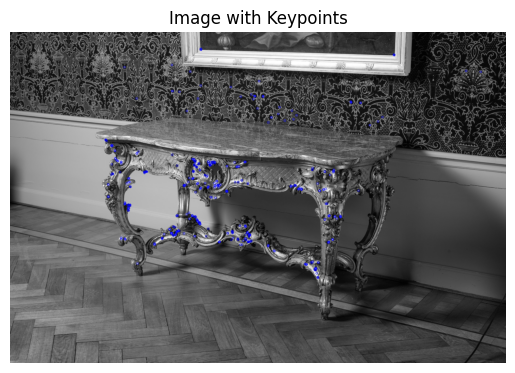

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_keypoints(image_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("The image path is invalid.")

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp, des = orb.detectAndCompute(gray, None)

    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(gray, kp, None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)

    # Display the image with keypoints
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title('Image with Keypoints')
    plt.axis('off')
    plt.show()

# Example usage:
image_path = 'test_dataset_gray/tafel_nk.jpg'
visualize_keypoints(image_path)
